# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [122]:
# import libraries here; add more as necessary
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

from scipy.stats import itemfreq, chisquare


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [125]:
import warnings
warnings.filterwarnings('ignore')

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape



(891221, 85)

In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
feat_info.shape

(85, 4)

In [7]:
feat_info['type'].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

In [8]:
feat_info.loc[feat_info['type'] == 'numeric'].head()

,attribute,information_level,type,missing_or_unknown
11,GEBURTSJAHR,person,numeric,[0]
44,ANZ_PERSONEN,household,numeric,[]
45,ANZ_TITEL,household,numeric,[]
50,ANZ_HAUSHALTE_AKTIV,building,numeric,[0]
51,ANZ_HH_TITEL,building,numeric,[]


In [9]:
azdias['ANZ_TITEL'].unique()

array([ nan,   0.,   1.,   2.,   4.,   3.,   6.])

In [10]:
for feat_type in feat_info['type'].unique():
    print('num of features with type: {} = {}'.format(feat_type, feat_info.loc[feat_info['type'] == feat_type].shape[0]))

num of features with type: categorical = 21
num of features with type: ordinal = 49
num of features with type: numeric = 7
num of features with type: mixed = 7
num of features with type: interval = 1


In [11]:
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# unique values of missing_or_unknown column in feat_info file
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [13]:
# parse string to list of missing values
def parse_to_list(string):
    values = string[1:-1].split(',')
    return [int(i) if i and not i.isalpha() else i.strip() for i in values ]

In [14]:
print(parse_to_list('[-1,XX]'))
print(parse_to_list('[-1,0,9]'))

[-1, 'XX']
[-1, 0, 9]


In [15]:
# convert missing_or_unknown column to list
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(parse_to_list)

In [16]:
# create a dict for features and corresponding missing values 
missing_data_dict = dict(zip(feat_info['attribute'], feat_info['missing_or_unknown']))

In [17]:
missing_data_dict

{'AGER_TYP': [-1, 0],
 'ALTERSKATEGORIE_GROB': [-1, 0, 9],
 'ANREDE_KZ': [-1, 0],
 'CJT_GESAMTTYP': [0],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_VORSORGER': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZTYP': [-1],
 'GEBURTSJAHR': [0],
 'GFK_URLAUBERTYP': [''],
 'GREEN_AVANTGARDE': [''],
 'HEALTH_TYP': [-1, 0],
 'LP_LEBENSPHASE_FEIN': [0],
 'LP_LEBENSPHASE_GROB': [0],
 'LP_FAMILIE_FEIN': [0],
 'LP_FAMILIE_GROB': [0],
 'LP_STATUS_FEIN': [0],
 'LP_STATUS_GROB': [0],
 'NATIONALITAET_KZ': [-1, 0],
 'PRAEGENDE_JUGENDJAHRE': [-1, 0],
 'RETOURTYP_BK_S': [0],
 'SEMIO_SOZ': [-1, 9],
 'SEMIO_FAM': [-1, 9],
 'SEMIO_REL': [-1, 9],
 'SEMIO_MAT': [-1, 9],
 'SEMIO_VERT': [-1, 9],
 'SEMIO_LUST': [-1, 9],
 'SEMIO_ERL': [-1, 9],
 'SEMIO_KULT': [-1, 9],
 'SEMIO_RAT': [-1, 9],
 'SEMIO_KRIT': [-1, 9],
 'SEMIO_DOM': [-1, 9],
 'SEMIO_KAEM': [-1, 9],
 'SEMIO_PFLICHT': [-1, 9],
 'SEMIO_TRADV': [-1, 9],
 'SHOPPER_TYP': [-1],
 'SOHO_KZ': [-

In [18]:
# Convert to nans using the missing_data_dict
for col in missing_data_dict.keys():
    nans_before = azdias[col].isnull().sum()
    azdias.loc[azdias[col].isin(missing_data_dict[col]), col] = np.nan
    nans_after = azdias[col].isnull().sum()
    if nans_after != nans_before:
        print(col)
        print('nans before: ', nans_before)
        print('nans after: ', nans_after)
        print('-'*20)


AGER_TYP
nans before:  0
nans after:  685843
--------------------
ALTERSKATEGORIE_GROB
nans before:  0
nans after:  2881
--------------------
GEBURTSJAHR
nans before:  0
nans after:  392318
--------------------
HEALTH_TYP
nans before:  0
nans after:  111196
--------------------
LP_LEBENSPHASE_FEIN
nans before:  4854
nans after:  97632
--------------------
LP_LEBENSPHASE_GROB
nans before:  4854
nans after:  94572
--------------------
LP_FAMILIE_FEIN
nans before:  4854
nans after:  77792
--------------------
LP_FAMILIE_GROB
nans before:  4854
nans after:  77792
--------------------
NATIONALITAET_KZ
nans before:  0
nans after:  108315
--------------------
PRAEGENDE_JUGENDJAHRE
nans before:  0
nans after:  108164
--------------------
SHOPPER_TYP
nans before:  0
nans after:  111196
--------------------
TITEL_KZ
nans before:  73499
nans after:  889061
--------------------
VERS_TYP
nans before:  0
nans after:  111196
--------------------
ALTER_HH
nans before:  73499
nans after:  310267
------

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [19]:
# Perform an assessment of how much missing data there is in each column of the dataset.
feat_nan_pct = (azdias.isnull().mean()).sort_values(ascending=False)
feat_nan_pct[:25]

TITEL_KZ          0.997576
AGER_TYP          0.769554
KK_KUNDENTYP      0.655967
KBA05_BAUMAX      0.534687
GEBURTSJAHR       0.440203
ALTER_HH          0.348137
REGIOTYP          0.177357
KKK               0.177357
W_KEIT_KIND_HH    0.166051
KBA05_ANTG4       0.149597
KBA05_GBZ         0.149597
MOBI_REGIO        0.149597
KBA05_ANTG1       0.149597
KBA05_ANTG2       0.149597
KBA05_ANTG3       0.149597
PLZ8_GBZ          0.130736
PLZ8_HHZ          0.130736
PLZ8_BAUMAX       0.130736
PLZ8_ANTG4        0.130736
PLZ8_ANTG1        0.130736
PLZ8_ANTG3        0.130736
PLZ8_ANTG2        0.130736
SHOPPER_TYP       0.124768
VERS_TYP          0.124768
HEALTH_TYP        0.124768
dtype: float64

In [20]:
col_miss_df = feat_nan_pct.to_frame()
col_miss_df.reset_index(level=0, inplace=True)
col_miss_df.columns = ['feature','miss_pct']
col_miss_df['information_level'] = feat_info['information_level']
col_miss_df['type'] = feat_info['type']
col_miss_df.head(2)

,feature,miss_pct,information_level,type
0,TITEL_KZ,0.997576,person,categorical
1,AGER_TYP,0.769554,person,ordinal


In [21]:
# num of features don't have nans
col_miss_df[col_miss_df['miss_pct'] == 0].shape[0]

24

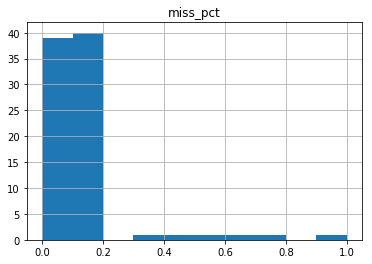

In [22]:
# plot histgram to visualize distribution of missing rate
col_miss_df.hist();

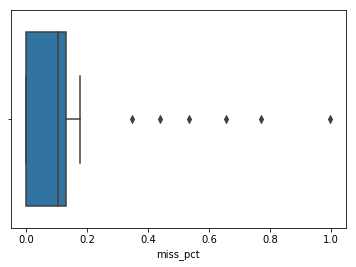

In [23]:
sns.boxplot(col_miss_df['miss_pct']);

In [24]:
# Features with the higher NaN values
col_miss_df[col_miss_df['miss_pct']>0.2].shape[0]

6

In [25]:
col_miss_df[col_miss_df['miss_pct']==0].shape[0]

24

In [26]:
# Investigate patterns in the amount of missing data in each column.
conditions = [
    (col_miss_df['miss_pct'] == 0),
    (col_miss_df['miss_pct'] > 0) & (col_miss_df['miss_pct'] <= 0.05),
    (col_miss_df['miss_pct'] > 0.05) & (col_miss_df['miss_pct'] <= 0.2),
    (col_miss_df['miss_pct'] > 0.2)
    ]
values = ['no_nan', 'low', 'medium', 'high']
col_miss_df['nan_degree'] = np.select(conditions, values)
col_miss_df.head()

,feature,miss_pct,information_level,type,nan_degree
0,TITEL_KZ,0.997576,person,categorical,high
1,AGER_TYP,0.769554,person,ordinal,high
2,KK_KUNDENTYP,0.655967,person,categorical,high
3,KBA05_BAUMAX,0.534687,person,categorical,high
4,GEBURTSJAHR,0.440203,person,ordinal,high


In [27]:
col_miss_df.describe()

,miss_pct
count,85.000000
mean,0.110541
std,0.164498
min,0.000000
25%,0.000000
50%,0.104517
75%,0.130736
max,0.997576


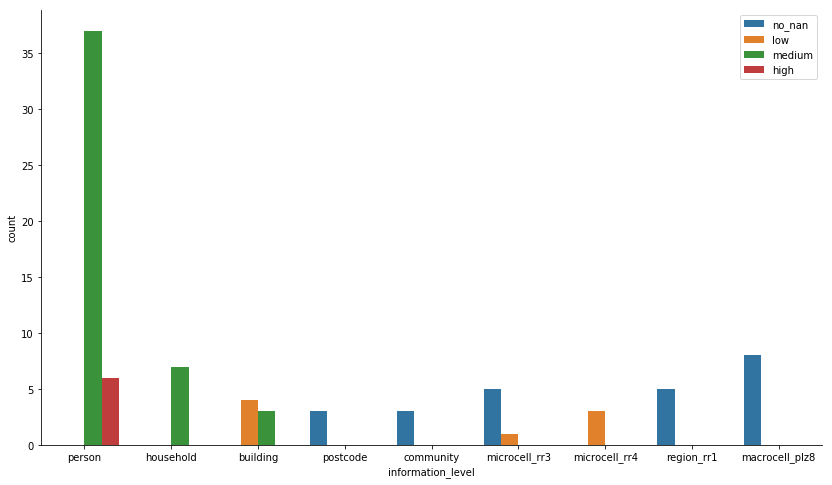

In [28]:
fig, ax1 = plt.subplots(figsize=(14,8))
order = ['person', 'household', 'building', 'postcode', 'community',
       'microcell_rr3', 'microcell_rr4', 'region_rr1', 'macrocell_plz8']
hue_order = ['no_nan', 'low', 'medium', 'high']
sns.countplot(data=col_miss_df,
              x='information_level',
              hue='nan_degree',
              order=order,
              hue_order=hue_order,
              ax=ax1)
plt.legend(loc='upper right')
sns.despine(ax=ax1);

In [29]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outliers_features = col_miss_df[col_miss_df['miss_pct']>0.2].feature
azdias.drop(outliers_features, axis=1, inplace=True)
azdias.shape

(891221, 79)

In [30]:
print(outliers_features)

0        TITEL_KZ
1        AGER_TYP
2    KK_KUNDENTYP
3    KBA05_BAUMAX
4     GEBURTSJAHR
5        ALTER_HH
Name: feature, dtype: object


#### Discussion 1.1.2: Assess Missing Data in Each Column

- Observations:
    - Average value of missing rate across all features = 11.05%
    - 75% features have missing rate less than 13.07%
    - The majority of features have less than 20% missing values.
    - Num of features with a considerably higher number of missing values = 6
    - Num of features with Zero missing values = 24
    - Person features tend to have higher unusual missing rates.
    - The colunms that are removed are those with missing rate higher than 20%: **[TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH]**

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [31]:
# How much data is missing in each row of the dataset?
azdias['row_nan_pct'] = azdias.isnull().mean(axis=1) 

In [32]:
print(azdias['row_nan_pct'].describe())

count    891221.000000
mean          0.071518
std           0.167528
min           0.000000
25%           0.000000
50%           0.000000
75%           0.037975
max           0.620253
Name: row_nan_pct, dtype: float64


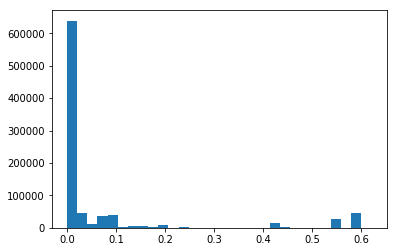

In [33]:
plt.hist(azdias['row_nan_pct'], bins=30);

In [34]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshhold = 0.1

low_nan_rows = azdias.loc[azdias['row_nan_pct'] < threshhold]
high_nan_rows = azdias.loc[azdias['row_nan_pct'] > threshhold]
print('num of rows have missing values < 0.1 = {}, with percentage of {}%'.format(low_nan_rows.shape[0], (low_nan_rows.shape[0]/azdias.shape[0])*100))
print('num of rows have missing values > 0.1 = {}, with percentage of {}%'.format(high_nan_rows.shape[0], (high_nan_rows.shape[0]/azdias.shape[0])*100))

num of rows have missing values < 0.1 = 747109, with percentage of 83.82982447675717%
num of rows have missing values > 0.1 = 144112, with percentage of 16.170175523242833%


In [35]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# no nan columns of low nan rows:
low_nan_columns = low_nan_rows.dropna(axis=1)

# no nan columns of high nan rows:
high_nan_columns = high_nan_rows.dropna(axis=1)

In [36]:
no_nan_columns = list(set(low_nan_columns.columns).intersection(high_nan_columns.columns))

In [37]:
print('num of columns with no missing values = {}'.format(len(no_nan_columns)))
no_nan_columns[:6]

num of columns with no missing values = 25


['SEMIO_SOZ',
 'FINANZ_MINIMALIST',
 'SEMIO_RAT',
 'GREEN_AVANTGARDE',
 'SEMIO_ERL',
 'FINANZ_ANLEGER']

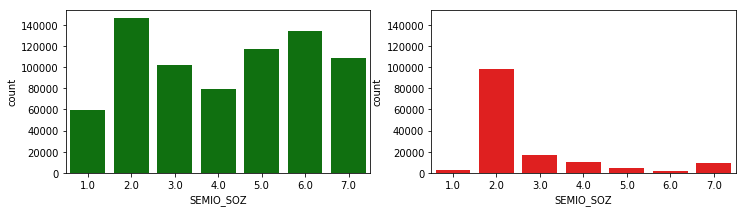

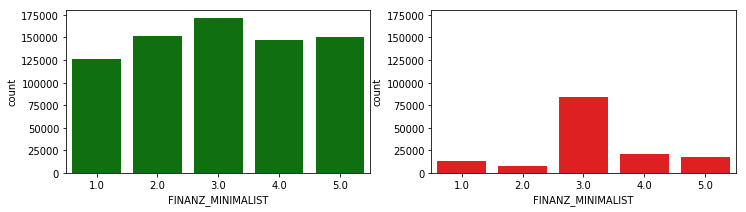

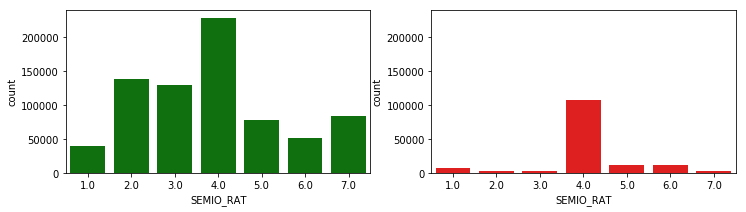

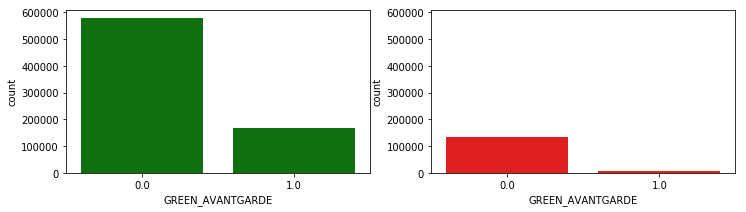

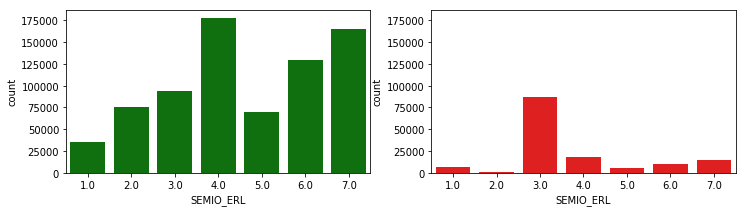

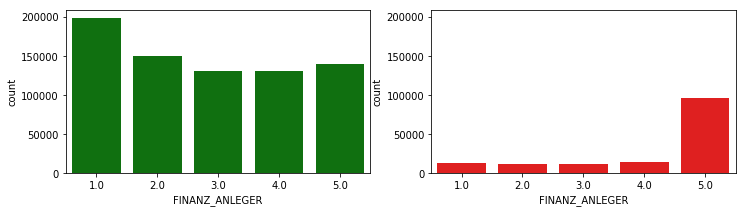

In [38]:
# draw count plot to compare between two groups
def compare(column, df1, df2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    ax1 = plt.subplot(1,2,1)
    ax1 = sns.countplot(df1[column], color='g')
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    ax2 = sns.countplot(df2[column], color='r')
    plt.show()

# compare with first 6 columns
for col in no_nan_columns[:6]:
    compare(col, low_nan_columns, high_nan_columns)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

- Observations:
    - 75% rows have missing rate = 0.037975
    - Max amount of missing values in a row = 0.620253
    - Threshhold of 0.1 is used to split the data into 2 groups to compare the distribution.
    - Percentage of rows have missing values < 0.1 = 83.829
    - Percentage of rows have missing values > 0.1 = 16.170
    - The distributions of select 6 columns are discrete and look distinctly different.
    
####  So we will continue the analysis with the dataset that contains rows with less than 10% NaNs

In [39]:
# Keep only the rows with NaNs pct below 10%
df = low_nan_rows
# Drop the 'row_nan_pct' column
df = df.drop('row_nan_pct', axis=1)
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [40]:
print(df.shape)

(747109, 79)


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [41]:
feat_info['type'].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

In [42]:
# filter feat_info to the remaining columns
feat_info = feat_info[feat_info.columns[:-1]]
feat_info = feat_info[feat_info.attribute.isin(df.columns)]
feat_info.shape

(79, 3)

In [43]:
# How many features are there of each data type?
for feat_type in feat_info['type'].unique():
    print('num of features with type: {} = {}'.format(feat_type, feat_info.loc[feat_info['type'] == feat_type].shape[0]))

num of features with type: ordinal = 49
num of features with type: categorical = 18
num of features with type: mixed = 6
num of features with type: numeric = 6


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [44]:
feat_info.head()

,attribute,information_level,type
1,ALTERSKATEGORIE_GROB,person,ordinal
2,ANREDE_KZ,person,categorical
3,CJT_GESAMTTYP,person,categorical
4,FINANZ_MINIMALIST,person,ordinal
5,FINANZ_SPARER,person,ordinal


In [45]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Get the categorical feature names
df_cat_cols = feat_info[feat_info.type == 'categorical'].attribute
df_cat_cols

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [46]:
df[df_cat_cols].nunique().sort_values()

ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
SOHO_KZ              2
GREEN_AVANTGARDE     2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
FINANZTYP            6
ZABEOTYP             6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

In [47]:
df[df_cat_cols].dtypes

ANREDE_KZ           float64
CJT_GESAMTTYP       float64
FINANZTYP           float64
GFK_URLAUBERTYP     float64
GREEN_AVANTGARDE    float64
LP_FAMILIE_FEIN     float64
LP_FAMILIE_GROB     float64
LP_STATUS_FEIN      float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
SOHO_KZ             float64
VERS_TYP            float64
ZABEOTYP            float64
GEBAEUDETYP         float64
OST_WEST_KZ          object
CAMEO_DEUG_2015      object
CAMEO_DEU_2015       object
dtype: object

The last three columns are of dtype object.

In [48]:
df[df_cat_cols[-3:]].head()

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,W,8,8A
2,W,4,4C
3,W,2,2A
4,W,6,6B
5,W,8,8C


- OST_WEST_KZ: has two values [O, W]
- CAMEO_DEUG_2015: has 9 numeric values encoded as object dtype.
- CAMEO_DEU_2015: has 44 values and it is a more detailed version CAMEO_DEUG_2015.

In [49]:
# encode OST_WEST_KZ values
df['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [50]:
df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O': 0, 'W': 1})

In [51]:
# Select the multilevel categorical features
cat_nunique = df[df_cat_cols].nunique()
cat_to_encode = cat_nunique[cat_nunique>2]
cat_to_encode.sort_values()

NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_FAMILIE_GROB      5
LP_STATUS_GROB       5
CJT_GESAMTTYP        6
FINANZTYP            6
ZABEOTYP             6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

In [52]:
# Drop the multilevel categorical features to keep things straightforward
df = df.drop(columns=cat_to_encode.index, axis=0)

In [53]:
df.shape

(747109, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

- Data contains 18 categorical features, including 5 binary and 13 multilevel features.
- OST_WEST_KZ: has two values [O, W] which re-encoded to values [0, 1]
- The rest of the binary features will be kept without re-encoding.
- To keep things straightforward, 13 multilevel features are dropped.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [54]:
mixed_cols = feat_info.loc[feat_info['type'] == 'mixed'].attribute
mixed_cols

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [55]:
df[mixed_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747109 entries, 1 to 891220
Data columns (total 6 columns):
LP_LEBENSPHASE_FEIN      714735 non-null float64
LP_LEBENSPHASE_GROB      717274 non-null float64
PRAEGENDE_JUGENDJAHRE    730988 non-null float64
WOHNLAGE                 747109 non-null float64
CAMEO_INTL_2015          743878 non-null object
PLZ8_BAUMAX              744272 non-null float64
dtypes: float64(5), object(1)
memory usage: 59.9+ MB


In [56]:
df[mixed_cols].nunique().sort_values()

PLZ8_BAUMAX               5
WOHNLAGE                  8
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
CAMEO_INTL_2015          21
LP_LEBENSPHASE_FEIN      40
dtype: int64

In [57]:
df['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '41', '34',
       '55', '33', '25', nan, '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [58]:
df['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   9.,   6.,   4.,  nan,   5.,
         2.,   1.,  12.,  13.,   7.])

In [59]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
decade_dict = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,
               8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,
               14: 6, 15: 6
              }
movement_dict = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2
                }

# It appears that map is approximately 10x faster than replace.
# Ref: https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict
df['ENG_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
df['ENG_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)

In [60]:
print(df['ENG_DECADE'].value_counts())

6.0    212488
4.0    166658
5.0    142337
3.0    110730
2.0     71852
1.0     26923
Name: ENG_DECADE, dtype: int64


In [61]:
print(df['ENG_MOVEMENT'].value_counts())

1.0    564070
2.0    166918
Name: ENG_MOVEMENT, dtype: int64


In [62]:
def get_digit(num,digit):
    if not pd.isnull(num):
        num = int(str(num)[digit])
    return num

In [63]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
df['ENG_WEALTH'] = df['CAMEO_INTL_2015'].apply(get_digit, digit=0)
df['ENG_LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(get_digit, digit=1)

In [64]:
print(df['ENG_WEALTH'].value_counts())

5.0    213978
4.0    181187
2.0    174240
1.0    111831
3.0     62642
Name: ENG_WEALTH, dtype: int64


In [65]:
print(df['ENG_LIFE_STAGE'].value_counts())

1.0    232220
4.0    220077
5.0    111547
3.0    108061
2.0     71973
Name: ENG_LIFE_STAGE, dtype: int64


In [66]:
# Drop mixed dtype features
df = df.drop(mixed_cols, axis=1)
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ENG_DECADE,ENG_MOVEMENT,ENG_WEALTH,ENG_LIFE_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [67]:
df.shape

(747109, 64)

#### Discussion 1.2.2: Engineer Mixed-Type Features

- Dataset contains 6 features of mixed type.
- Two new variables called **[ENG_DECADE, ENG_MOVEMENT]** have been engineered from the mixed feature **"PRAEGENDE_JUGENDJAHRE"** which combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). **[ENG_DECADE, ENG_MOVEMENT]**  capture the two dimensions of original feature: an interval-type variable for decade, and a binary variable for movement.
- Two new variables called **[ENG_WEALTH, ENG_LIFE_STAGE]** have been engineered from the mixed feature **"CAMEO_INTL_2015"** which combines information on two axes: wealth and life stage. **[ENG_WEALTH, ENG_LIFE_STAGE]** capture meaning from the original feature by breaking up the original two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables
- The other 4 mixed features will be dropped to keep things more straightforward.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [68]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
df.shape

(747109, 64)

In [69]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
df.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEI

In [70]:
# check all data types
df.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [106]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = convert_missingdata_encodings_to_nans(df)
    print('Convert missing value codes into NaN, OK')

    # remove selected columns , ...
    df = drop_selected_columns(df)
    # remove selected rows and return both dfs
    df, df_cust_highna = drop_selected_rows(df)
    print('Remove selected columns and rows, OK')
    
    # select, re-encode, and engineer column values.
    df = reencode_categorical_feat(df)
    df = engineer_mixed_feat(df)
    print('Select, re-encode, and engineer column value, OK')
    
    # Return the cleaned dataframe and the high NaN Df.
    return df, df_cust_highna


def convert_missingdata_encodings_to_nans(df, debug=False):
    '''Convert to nans using the missing_data_encode dictionary'''

    for col in missing_data_dict.keys():
        if debug:
            print(col, 'nans before: ', df[col].isnull().sum())
        df.loc[df[col].isin(missing_data_dict[col]), col] = np.nan
        if debug:
            print(col, 'nans after: ', df[col].isnull().sum(), '\n')
    return df


def drop_selected_columns(df):
    ''''''
    return df.drop(columns=outliers_features, axis=1)


def drop_selected_rows(df):
    '''split the dataset into two parts:
    One with a percntage of NaN per row over the threshhold
    and one below. Return both.'''
    threshhold = 0.1
    df['row_nan_perc'] = df.isnull().mean(axis=1)
    
    df_lowna = df.loc[df['row_nan_perc'] < threshhold, :].\
                                drop(columns='row_nan_perc', axis=1)
    df_highna = df.loc[df['row_nan_perc'] > threshhold, :].\
                                drop(columns='row_nan_perc', axis=1)

    return df_lowna, df_highna


def reencode_categorical_feat(df):
    ''''''
    # Reencode the binary OST_WEST_KZ to numeric categories
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O': 0,
                                                   'W': 1})

    # choose the categorical features with more than 2 levels
    df_cat_cols = feat_info[feat_info.type == 'categorical'].attribute
    cat_nunique = df[df_cat_cols].nunique()
    cat_to_encode = cat_nunique[cat_nunique > 2]

    # DROP THE MULTI-LEVEL CATEGORICAL FEATURES
    df = df.drop(columns=cat_to_encode.index, axis=0)

    return df


def engineer_mixed_feat(df):
    '''Engineer new variables from the 
    mixed features. Drop he old features'''
    # Engineer two new variables from 'PRAEGENDE_JUGENDJAHRE'
    decade_dict = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,
                   8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,
                   14: 6, 15: 6
                   }
    movement_dict = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                     2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2
                     }

    df['ENG_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    df['ENG_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    df.drop

    # Engineer two new variables from 'CAMEO_INTL_2015'
    df['ENG_WEALTH'] = df['CAMEO_INTL_2015'].apply(
        get_digit, digit=0)
    df['ENG_LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(
        get_digit, digit=1)

    # Drop mixed dtype features
    mixed_feat_cols = feat_info[feat_info.type == 'mixed'].attribute
    df = df.drop(mixed_feat_cols, axis=1)

    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [72]:
# check missing rate
df.isnull().mean().describe()

count    64.000000
mean      0.006708
std       0.013393
min       0.000000
25%       0.000000
50%       0.000034
75%       0.004917
max       0.060785
dtype: float64

In [73]:
# Percentage of nans per column
(df.isnull().mean(axis=0) * 100).sort_values(ascending=False)[:15]

W_KEIT_KIND_HH         6.078497
KKK                    5.410188
REGIOTYP               5.410188
HEALTH_TYP             3.260033
VERS_TYP               3.260033
ENG_MOVEMENT           2.157784
ENG_DECADE             2.157784
KBA05_ANTG1            1.470870
KBA05_ANTG3            1.470870
KBA05_ANTG4            1.470870
KBA05_GBZ              1.470870
MOBI_REGIO             1.470870
KBA05_ANTG2            1.470870
ANZ_HAUSHALTE_AKTIV    0.711543
ARBEIT                 0.499659
dtype: float64

In [74]:
# Percentage of nans per row 
nan_perc = (df.isnull().mean(axis=1) * 100).sort_values(ascending=False)

#How many rows have nans?
num_nan_rows = nan_perc[nan_perc > 0].shape[0]

In [75]:
print('num of rows with nan values = {}'.format(num_nan_rows))

num of rows with nan values = 123898


In [76]:
# as a percentage of rows
print('Total percentage of rows that have NaNs : ', round(num_nan_rows/ df.shape[0]  * 100, 4),'%')

Total percentage of rows that have NaNs :  16.5837 %


In [77]:
# Fit the Scaler without NaNs
no_nan_df = df.dropna(axis=0)
scaler = StandardScaler()
scaler.fit(no_nan_df)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [78]:
# Imput missing values in the full df with the mean
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_impute = imp.fit_transform(df)

In [79]:
# Transform the df with the fitted scaler
X_scale = scaler.transform(X_impute)

In [80]:
df_scale = pd.DataFrame(X_scale, columns=df.columns)
df_scale.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ENG_DECADE,ENG_MOVEMENT,ENG_WEALTH,ENG_LIFE_STAGE
count,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,...,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000
mean,0.003698,0.015413,0.001930,0.008389,-0.000648,0.030617,0.024543,-0.011613,-0.026449,0.000891,...,-0.020237,-0.002344,0.020456,-0.019430,-0.034443,-0.021471,0.005359,-0.014822,-0.029240,-0.000760
std,0.997498,0.999536,1.006980,1.008161,0.995106,1.011898,1.009243,1.015730,0.982942,0.979313,...,0.993209,1.009009,0.996363,1.003865,0.999515,1.002373,0.995194,0.979819,1.003429,0.992829
min,-1.746287,-1.022678,-1.512226,-1.141397,-1.765054,-1.221852,-1.139026,-1.588887,-0.553672,-1.591635,...,-0.981973,-2.721004,-2.111170,-2.223015,-1.914219,-1.563993,-2.280170,-0.553672,-1.595951,-1.251111
25%,-0.772089,-1.022678,-0.777350,-1.141397,-1.045045,-1.221852,-1.139026,-0.856544,-0.553672,-0.273495,...,-0.981973,-0.639701,-0.314765,-0.201175,-0.607437,-0.823841,-0.902320,-0.553672,-0.909992,-1.251111
50%,0.202108,0.977825,-0.042475,0.219832,0.394972,0.158605,-0.410325,-0.124201,-0.553672,-0.273495,...,0.384671,-0.002344,-0.314765,-0.201175,-0.171843,-0.083688,-0.213395,-0.553672,0.461926,0.082843
75%,1.176305,0.977825,0.692400,0.900446,1.114980,0.848833,1.047076,0.608142,-0.553672,1.044646,...,0.384671,0.400951,0.583438,0.809745,0.699344,0.656464,1.164455,-0.553672,1.147884,0.749820
max,1.176305,0.977825,1.427276,1.581061,1.114980,1.539061,1.775776,1.340485,1.806125,1.044646,...,1.751315,1.441603,1.481641,1.820665,1.570532,1.396616,1.164455,1.806125,1.147884,1.416797


### Discussion 2.1: Apply Feature Scaling

- Percentage of rows that contain NanNs is 16,37%.
- Droping them would discard a significant amount of data in order to handle much smaller amount of actually missing data.
- StandardScaler is used to fit the data without the NaNs and then reintroduce them, imputing them with the mean and transforming them with the fitted StandardScaler object thus resulting in a distributions that retain a higher amount of information.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [81]:
X_scale.shape

(747109, 64)

In [82]:
# Apply PCA to the data.
pca = PCA()
df_pca = pca.fit_transform(X_scale)

In [83]:
# check components number should be the same as total features
components_total = len(pca.explained_variance_ratio_)
# generate sequence for plotting
components = np.arange(components_total)

Text(0.5,1,'Cumulative Explained Variance vs No. of Principal Components')

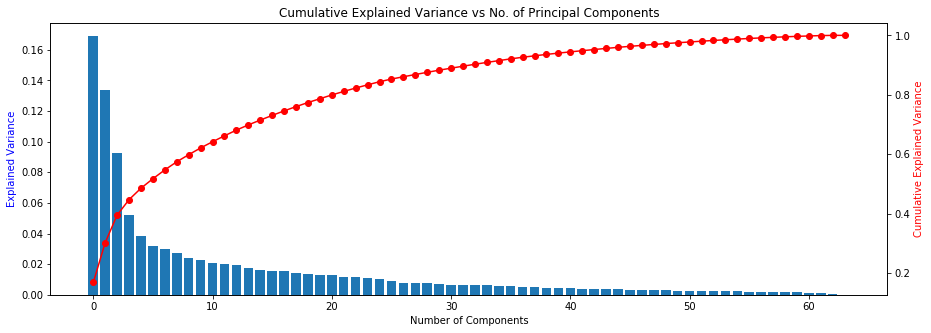

In [84]:
# Investigate the variance accounted for by each principal component.
# refer to this blog:https://github.com/S-Tabor/udacity-customer-segmentation-project/blob/master/identify_customer_segments_final.ipynb
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.bar(components, pca.explained_variance_ratio_)
ax1.set_ylabel('Explained Variance', color="blue")
ax1.set_xlabel('Number of Components')

ax2 = ax1.twinx() 
ax2.plot(np.cumsum(pca.explained_variance_ratio_), color="red",marker='o')
ax2.set_ylabel('Cumulative Explained Variance', color="red")
plt.title("Cumulative Explained Variance vs No. of Principal Components")

In [85]:
np.cumsum(pca.explained_variance_ratio_[:25])[-1]

0.84406757032126845

In [86]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=25)
pca_25 = pca.fit_transform(X_scale)
pca_25_df = pd.DataFrame(pca_25)

### Discussion 2.2: Perform Dimensionality Reduction

- PCA method is used on the scaled dataset and plot explained variance against the number of components together with cumulative explained variance.
- 25 components are kept to retain 84% of cumulative explained variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [87]:
len(pca.components_[0])

64

In [88]:
df_scale.shape

(747109, 64)

In [89]:
# the weights df
weights = pd.DataFrame(np.round(pca.components_, 4), columns=df_scale.columns)
weights.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ENG_DECADE,ENG_MOVEMENT,ENG_WEALTH,ENG_LIFE_STAGE
0,-0.1175,0.0057,-0.2193,0.1436,-0.1105,0.0650,0.0734,0.1645,-0.1083,0.0283,...,0.2178,0.0419,-0.1672,0.1441,0.1970,0.1353,0.0997,-0.1068,0.2078,-0.1236
1,0.2604,0.0864,0.0719,-0.2418,0.2337,-0.2121,-0.2312,0.1161,-0.0134,-0.0581,...,0.0861,0.0130,-0.0694,0.0652,0.0882,0.0630,-0.2515,-0.0113,0.0709,0.0028
2,0.0765,-0.3727,0.1599,-0.1035,0.0975,-0.1905,-0.0951,-0.0495,0.0501,-0.0151,...,0.0432,0.0052,-0.0358,0.0323,0.0462,0.0305,-0.1049,0.0493,0.0237,-0.0079
3,-0.0435,0.0403,0.0639,-0.0002,-0.0163,-0.1265,0.0906,-0.1095,0.3894,0.0054,...,0.0795,0.1483,0.0426,0.0463,0.2498,0.0939,0.0399,0.3876,-0.1281,0.0596
4,0.0054,0.0079,0.0860,-0.0064,-0.0647,0.0360,-0.0460,-0.0978,0.0636,0.0130,...,0.0316,-0.4701,-0.3933,0.2176,0.0950,0.1407,0.0284,0.0613,-0.0117,0.0211


In [90]:
def get_cpn_feat_wgt(pca, df, cpn_num):
    """Give feature weight of n-th component of pca object
    
    Args:
    pca: pca object. The fitted pca. 
    df: data frame. Original feature data frame.
    cpn_num: int. n-th component.
    
    Returns:
    weight_n: data frame. Feature weight of n-th component.
    """
    
    weights = pd.DataFrame(np.round(pca.components_, 4), columns = df.columns)
    weight_n = weights.iloc[cpn_num - 1, :].sort_values()
    weight_n = weight_n.to_frame()
    weight_n.reset_index(level=0, inplace=True)
    weight_n.columns = ['colname','weight']
    return weight_n

In [91]:
def get_topn_feat(cpn_feat_wgt, n=5):
    """Give feature weight of n-th component of pca object
    
    Args:
    cpn_feat_wgt: data frame. The feature weight of a component.
    n: int. The number of top and tail features we want to see.
    
    Returns:
    top_n: data frame. Top N positive and N negative features and corresponding weight.
    """
    tail_n = cpn_feat_wgt.head(n).reset_index(drop=True)
    head_n = cpn_feat_wgt.tail(n).sort_values(by='weight',ascending=False).reset_index(drop=True)
    top_n = pd.concat([head_n, tail_n], axis=1)
    top_n.columns = ['top_pos_col','top_pos_col_weight','top_neg_col','top_neg_col_weight']
    return top_n

In [92]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
cpn_wgt_1st = get_cpn_feat_wgt(pca, df_scale, 1)
get_topn_feat(cpn_wgt_1st).style.bar(align='mid')

,top_pos_col,top_pos_col_weight,top_neg_col,top_neg_col_weight
0,PLZ8_ANTG3,0.2264,MOBI_REGIO,-0.2425
1,PLZ8_ANTG4,0.2178,PLZ8_ANTG1,-0.2245
2,HH_EINKOMMEN_SCORE,0.2082,KBA05_ANTG1,-0.223
3,ENG_WEALTH,0.2078,FINANZ_MINIMALIST,-0.2193
4,ORTSGR_KLS9,0.197,KBA05_GBZ,-0.2183


Top 5 Positive

- **PLZ8_ANTG3**: Number of 6-10 family houses in the PLZ8 region (0: no 6-10 family homes, 3: high share of 6-10 family homes)
- **PLZ8_ANTG4**: Number of 10+ family houses in the PLZ8 region (0: no 10+ family home, 2: - high share of 10+ family homes)
- **HH_EINKOMMEN_SCORE**: Estimated household net income (1: highest income, 6: very low income)
- **ENG_WEALTH**: Household wealth - Engineered (1: Wealthy Households, 5: Poorer Households)
- **ORTSGR_KLS9**:Size of community

Top 5 Negative

- **MOBI_REGIO**: Movement patterns (1: very high movement, 6: none)
- **FINANZ_MINIMALIST**: Financial typology - MINIMALIST: low financial interest (1: very high, 5: very low)
- **KBA05_ANTG1**: Number of 1-2 family houses in the microcell (0: no 1-2 family homes, 4: very high share of 1-2 family homes)
- **KBA05_GBZ**: Number of buildings in the microcell(1: 1-2 buildings;5: >=23 buildings)
- **PLZ8_ANTG1**: Number of 1-2 family houses in the PLZ8 region (0: no 1-2 family homes, 4: very high share of 1-2 family homes)

So the first component captures **population density and income**

In [93]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
cpn_wgt_1st = get_cpn_feat_wgt(pca, df_scale, 2)
get_topn_feat(cpn_wgt_1st).style.bar(align='mid')

,top_pos_col,top_pos_col_weight,top_neg_col,top_neg_col_weight
0,ALTERSKATEGORIE_GROB,0.2604,SEMIO_REL,-0.2609
1,FINANZ_VORSORGER,0.2337,ENG_DECADE,-0.2515
2,SEMIO_ERL,0.2297,FINANZ_SPARER,-0.2418
3,SEMIO_LUST,0.1812,FINANZ_UNAUFFAELLIGER,-0.2312
4,RETOURTYP_BK_S,0.1681,SEMIO_TRADV,-0.2276


Top 5 Positive

- **ALTERSKATEGORIE_GROB**: Estimated age based on given name analysis (1: < 30 years old, 4: > 60 years old, 9: uniformly distributed)
- **FINANZ_VORSORGER**: Financial be prepared(1: very high)
- **RETOURTYP_BK_S**: Return type
- **SEMIO_ERL**: Personality typology - event-oriented ( 1: highest affinity, 7: lowest affinity)
- **SEMIO_LUST**: Personality typology - sensual-minded ( 1: highest affinity, 7: lowest affinity)

Top 5 Negative

- **ENG_DECADE**: Person’s decade of youth (1: 40s , 6: 90s)
- **FINANZ_SPARER**: Financial typology - money-saver (1: Very high, 5: Very low)
- **SEMIO_REL**: Personality typology - religious ( 1: highest affinity, 7: lowest affinity)
- **FINANZ_UNAUFFAELLIGER**: Financial typology - inconspicuous (1: Very high, 5: Very low)
- **SEMIO_TRADV**: Personality typology

So the second component seems to indicate **age and personality**

In [94]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
cpn_wgt_1st = get_cpn_feat_wgt(pca, df_scale, 3)
get_topn_feat(cpn_wgt_1st).style.bar(align='mid')

,top_pos_col,top_pos_col_weight,top_neg_col,top_neg_col_weight
0,SEMIO_VERT,0.3524,ANREDE_KZ,-0.3727
1,SEMIO_SOZ,0.2664,SEMIO_KAEM,-0.3332
2,SEMIO_FAM,0.2529,SEMIO_DOM,-0.3087
3,SEMIO_KULT,0.2354,SEMIO_KRIT,-0.2713
4,FINANZ_MINIMALIST,0.1599,SEMIO_RAT,-0.2119


Top 5 Positive

- **SEMIO_VERT**: Personality typology - VERT: dreamful (1: highest affinity, 7: lowest affinity)
- **SEMIO_FAM**: Personality typology - family-minded ( 1: highest affinity, 7: lowest affinity)
- **SEMIO_SOZ**: Personality typology - SOZ: socially-minded (1: highest affinity, 7: lowest affinity)
- **SEMIO_KULT**: Personality typology - cultural-minded ( 1: highest affinity, 7: lowest affinity)
- **FINANZ_MINIMALIST**: Financial typology

Top 5 Negative

- **ANREDE_KZ**: Gender ( 1: male, 2: female)
- **SEMIO_KAEM**: Personality typology - KAEM: combative attitude ( 1: highest affinity, 7: lowest affinity)
- **SEMIO_DOM**: Personality typology - DOM: dominant-minded ( 1: highest affinity, 7: lowest affinity)
- **SEMIO_KRIT**: Personality typology - KRIT: critical-minded ( 1: highest affinity, 7: lowest affinity)
- **SEMIO_RAT**: Personality typology

So The third component seems to indicate **gender and personality**

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

- **1ST component** captures the population density and financial condition
    - [PLZ8_ANTG3, PLZ8_ANTG4, HH_EINKOMMEN_SCORE, ENG_WEALTH, ORTSGR_KLS9] have high positive weights correlated with **People that live in more densely populated areas and with lower financial affluence.**
    - [MOBI_REGIO, FINANZ_MINIMALIST, KBA05_ANTG1, KBA05_GBZ, PLZ8_ANTG1] have high negative weights correlated with **People that live in less densely populated areas and with higher financial affluence.**


- **2nd component** seems to indicate age,personality
    - [ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, RETOURTYP_BK_S, SEMIO_ERL, SEMIO_LUST] have high positive weights correlated with **Older people with lower financial preparation and home ownership that are less sensual and event oriented.**
    - [ENG_DECADE, FINANZ_SPARER, SEMIO_REL, FINANZ_UNAUFFAELLIGER, SEMIO_TRADV] have high negative weights correlated with **Younger generation, with lower religious affinity, lower money saving, less inconspicuous and less traditional minded.**


- **3rd component** seems to indicate gender,personality
    - [SEMIO_VERT, SEMIO_FAM, SEMIO_SOZ, SEMIO_KULT, FINANZ_MINIMALIST] have high positive weights correlated with **Men that are less dreamful, less socially-minded, less cultural-minded not financial minimalists and conservative return shopper types.**
    - [ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_RAT] have high negative weights correlated with **Women that are less dominant-minded, less critical-minded, less rational, have less combative attitude and are less prone to investing.**


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [95]:
max_cluster = 15  
scores = {}
for i in range(2, max_cluster):
    # run k-means clustering on the data and keep the score
    print(i)
    scores[i] = np.abs(KMeans(n_clusters=i).fit(pca_25).score(pca_25))

2
3
4
5
6
7
8
9
10
11
12
13
14


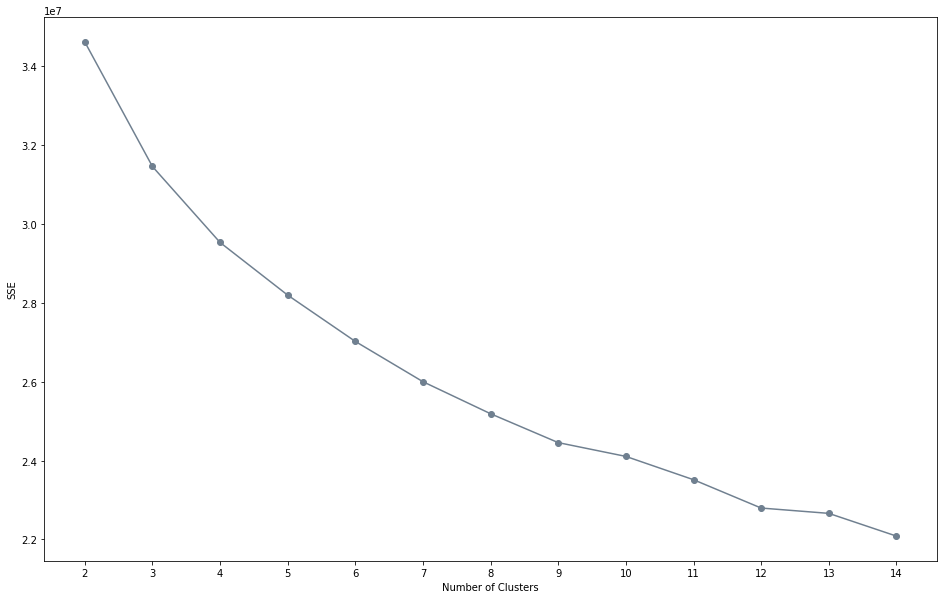

In [96]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
fig, ax = plt.subplots(figsize=(16,10))    
ax = pd.Series(scores).plot(marker='o', color='slategray')
ax.set_xticks(np.arange(2, max_cluster), minor=False);
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE");

In [97]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
clusters_num = 9
kmeans_model = KMeans(n_clusters=clusters_num, n_jobs=-1, random_state=0).fit(pca_25)

In [98]:
print(kmeans_model.labels_)

[5 6 6 ..., 3 7 4]


### Discussion 3.1: Apply Clustering to General Population

- The curve in the Distance to Number of Clusters relationship plot is **plotted aganist 15 cluster scores**.

- An obvious elbow in the curve where adding additional clusters less effective in reducing the within-cluster distance can be inferred to be **9 clusters** and this number has been used as the number of clusters to fit the the KMeans algorithm on the transformed demographics data and predict cluster labels.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [107]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [108]:
customers.shape

(191652, 85)

In [109]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [110]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
df_cust, df_cust_highna = clean_data(customers)

Convert missing value codes into NaN, OK
Remove selected columns and rows, OK
Select, re-encode, and engineer column value, OK


In [111]:
df_cust.shape

(133427, 64)

In [112]:
df_cust_highna.shape

(58225, 79)

In [113]:
# Feature transformation
# Impute
X_cust_imp = imp.transform(df_cust)

In [114]:
# Scale
X_cust_sc = scaler.transform(X_cust_imp)

In [115]:
# Dimensionality reduction
X_cust_pca = pca.transform(X_cust_sc)
X_cust_pca.shape

(133427, 25)

In [116]:
df_cust_pca = pd.DataFrame(X_cust_pca, columns=np.arange(1, 26))
df_cust_pca.describe()

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
count,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,...,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000
mean,-2.420121,1.310225,1.459638,0.926336,-0.021038,0.017390,0.159557,0.006043,0.218610,0.331010,...,0.111786,0.008328,0.215701,-0.209841,0.041691,0.138386,0.016471,0.022484,0.024198,-0.119216
std,2.719404,2.177324,2.195574,2.011810,1.504572,1.364384,1.366321,1.415994,1.265903,1.059389,...,1.080339,1.073269,0.752995,1.036479,1.212363,1.174703,0.806475,0.917382,0.785501,0.756968
min,-7.957291,-7.519120,-4.753565,-5.341116,-6.098238,-3.503259,-9.769573,-5.366594,-5.284718,-4.556009,...,-12.981623,-1.116020,-3.350681,-8.857510,-23.118446,-21.041421,-3.849230,-14.889198,-5.976454,-4.838951
25%,-4.481219,-0.028096,-0.776501,-0.708211,-0.982957,-0.792933,-0.346196,-0.996865,-0.635036,-0.388918,...,-0.543850,-0.131947,-0.266562,-0.800754,-0.539999,-0.445849,-0.501431,-0.467156,-0.522574,-0.647081
50%,-3.155340,1.249593,2.196788,0.962413,0.083596,-0.116105,0.300868,0.037560,0.180560,0.354690,...,0.086382,-0.094754,0.186023,-0.267316,-0.034099,0.077357,0.037230,0.049094,0.070688,-0.083373
75%,-0.792494,2.715569,3.232503,2.563867,1.013643,0.620167,0.919030,1.010944,1.042183,1.063898,...,0.715205,-0.058939,0.644267,0.264388,0.489573,0.602716,0.564079,0.541542,0.572566,0.418602
max,11.321036,10.919475,6.259991,9.462838,6.793035,29.692491,17.844792,7.610073,7.303221,5.469269,...,15.970780,10.943246,7.211263,21.317919,31.461145,28.311848,3.539890,19.073339,5.536410,4.899705


In [118]:
# Clustering
X_cust_kmeans = kmeans_model.predict(X_cust_pca)

In [119]:
np.unique(X_cust_kmeans)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [127]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
def count_group(df, group_name):
    """Compute the proportion of data points in each cluster for the data
    
    Args:
    df: data.frame. The clustered data
    group_name: char. The name of the data 
    
    Returns:
    per_group: data.frame. The percentage of each group of the data
    
    """
    per_group = pd.DataFrame(itemfreq(df["labels"]),columns=['label','freq'])
    per_group['group'] = group_name
    per_group['freq'] = per_group['freq']/per_group['freq'].sum()
    return per_group


In [129]:
pca_25_df["labels"] = kmeans_model.labels_
df_cust_pca["labels"] = X_cust_kmeans

In [130]:
pop_per_group = count_group(pca_25_df, 'population')
cus_per_group = count_group(df_cust_pca, 'customer')
total_per_group = pop_per_group.append(cus_per_group)
print(total_per_group)

   label      freq       group
0      0  0.089299  population
1      1  0.139798  population
2      2  0.165910  population
3      3  0.108997  population
4      4  0.135059  population
5      5  0.105135  population
6      6  0.163269  population
7      7  0.088213  population
8      8  0.004319  population
0      0  0.026022    customer
1      1  0.105683    customer
2      2  0.495320    customer
3      3  0.017890    customer
4      4  0.124495    customer
5      5  0.010313    customer
6      6  0.190029    customer
7      7  0.009893    customer
8      8  0.020356    customer


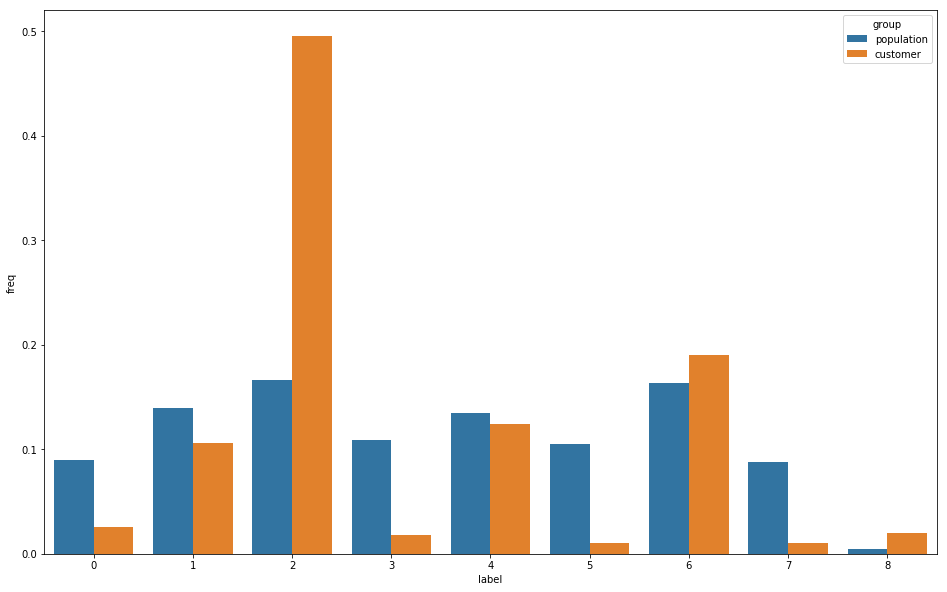

In [131]:
# make a visual plot
fig, ax = plt.subplots(figsize=(16,10))    
ax=sns.barplot(x='label', y='freq', hue='group', data=total_per_group)

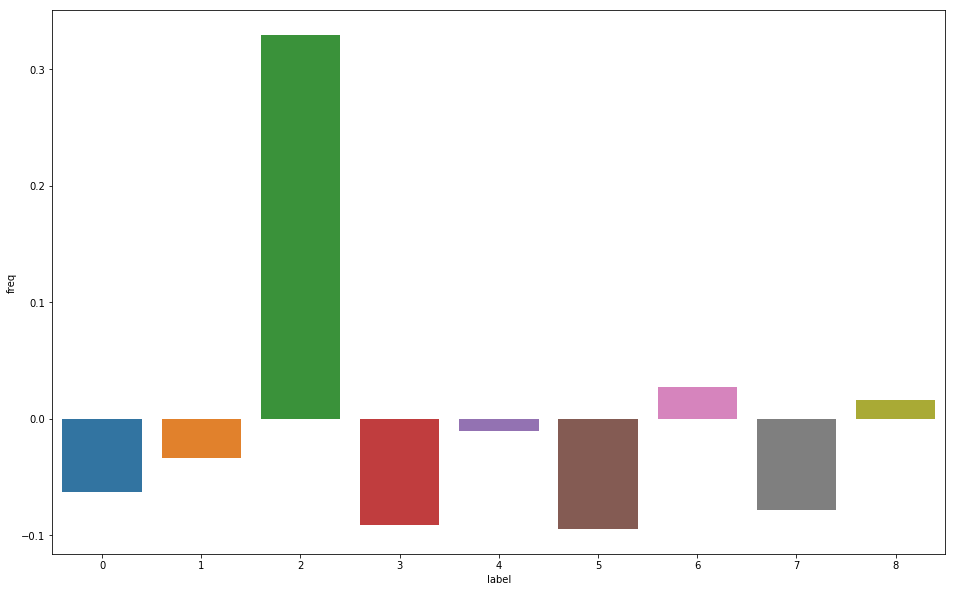

In [132]:
# make a visual plot about customer freq - population freq
fig, ax = plt.subplots(figsize=(16,10))
ax=sns.barplot(x=cus_per_group.label, y=cus_per_group.freq - pop_per_group.freq)

In [137]:
# Rename components for better reading
df_cust_pca = df_cust_pca.rename(columns = {1: 'pop_density-finance_status',
                                            2: 'age-generation',
                                            3: 'gender'}
                                )

In [145]:
def map_cluster_to_feats(kmeans, df, cnum):
    '''Map pca weights to  individual features
    and return two pd.Series on with the highest
    positive weights and one with the lowest negative
    weights
    
    Args:
    kmeans: kmeans object.
    df: data frame. The pca data frame of original data.
    cnum: int. The n-th cluster.
    
    Returns:
    top_pca_feat: data frame. The top N positive and negative pca features. 
    '''
    
    # get coordinates of cluster centers
    weights = pd.DataFrame(np.round(kmeans.cluster_centers_, 4), columns=df.keys())
    # the centroid of cluster cnum
    centroid = weights.iloc[cnum, :]
    # postive pca feature
    cent_pos = centroid[centroid > 0].sort_values(ascending=False).to_frame()
    cent_pos.reset_index(level=0, inplace=True)
    cent_pos.columns = ['top_pos_col','top_pos_col_weight']
    # negative pca feature
    cent_neg = centroid[centroid < 0].sort_values(ascending=True).to_frame()
    cent_neg.reset_index(level=0, inplace=True)
    cent_neg.columns = ['top_neg_col','top_neg_col_weight']
    # concat postive and negative
    top_pca_feat = pd.concat([cent_pos, cent_neg], axis=1)
    top_pca_feat['top_neg_col'] = top_pca_feat['top_neg_col'].apply(str)
    top_pca_feat['top_pos_col'] = top_pca_feat['top_pos_col'].apply(str)
    return top_pca_feat

In [144]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Overrepresented segment is cluster 2 by barplot
top_pca_feat = map_cluster_to_feats(kmeans_model, df_cust_pca.iloc[:, :-1], 2)
top_pca_feat.style.bar(align='mid')


,top_pos_col,top_pos_col_weight,top_neg_col,top_neg_col_weight
0,gender,2.2105,pop_density-finance_status,-3.4077
1,12,0.1494,9,-0.2108
2,8,0.1372,14,-0.1037
3,5,0.098,13,-0.0663
4,15,0.0856,10,-0.0653
5,11,0.0713,16,-0.0645
6,18,0.0561,25,-0.0456
7,24,0.04,age-generation,-0.0283
8,7,0.038,4,-0.0279
9,23,0.0203,21,-0.0235


In [146]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# underrepresented segment is cluster 5 by barplot
top_pca_feat = map_cluster_to_feats(kmeans_model, df_cust_pca.iloc[:, :-1], 5)
top_pca_feat.style.bar(align='mid')

,top_pos_col,top_pos_col_weight,top_neg_col,top_neg_col_weight
0,pop_density-finance_status,4.3928,gender,-2.6147
1,10,0.4733,age-generation,-1.2068
2,4,0.3524,8,-0.2689
3,18,0.1453,9,-0.17
4,11,0.1221,19,-0.1052
5,7,0.1045,25,-0.0859
6,16,0.103,6,-0.0778
7,24,0.1028,15,-0.0591
8,23,0.0752,13,-0.0509
9,5,0.0603,12,-0.0428


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Based on the comparison above:

- The Overrepresented customer segment is **cluster#2**, which has *high positive impact of gender component* and *high negtive impact of population density and financial condition component*.

- So the population that are relatively popular with the mail-order company are **relatively younger men** that are less dreamful, less socially-minded, less cultural-minded, not financial minimalists, conservative return shopper types, that have a higher financial status and **live in less densely populated areas**.



- The underrepresented customer segment is **cluster#5**, which has *high positive impact of population density and financial condition component* and *high negative gender & age-generation components*.

- So the population that are relatively unpopular with the mail-order company are **Younger women** that are less dominant-minded, less critical-minded, less rational, have a less combative attitude and are less prone to investing and **live in densely populated areas with a lower financial status. They have lower religious affinity, lower money saving culture and are less traditional minded.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.